# Generate orthorhombic dataset

In [1]:
import os

import numpy as np
from nexusformat.nexus import *
import matplotlib.pyplot as plt

from nxs_analysis_tools import plot_slice

In [4]:
# Base directory
base_dir = "data"

# Set temperatures
xs = [15,100,300]

# Create the folders
for x in xs:
    folder_name = f"{x}"  # Format x to one decimal place
    full_path = os.path.join(base_dir, folder_name)
    os.makedirs(full_path, exist_ok=True)

In [81]:
for idx, T in enumerate(xs):
    # Create array
    array_size = (100, 150, 200)
    array = np.zeros(array_size)
    
    # Create coordinates
    x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, array_size[0]),  # size of grid in real units
                          np.linspace(-2.5, 2.5, array_size[1]),
                          np.linspace(-3.5, 3.5, array_size[2]),
                          indexing='ij')
    
    # Grid parameters
    int_positions = [-3,-2,-1,0,1,2,3]  # integer crystallographic positions
    std_dev = 0.250  # in absolute coordinates (real units)
    amplitude_int = 1.0

    # Coordinate ranges
    x_range = x.max() - x.min()
    y_range = y.max() - y.min()
    z_range = z.max() - z.min()

    # Base std
    base_std = std_dev  

    # Axis-specific stds to make Gaussian look circular under orthorhombic aspect ratio
    std_x = base_std
    std_y = base_std * (2 / 1)
    std_z = base_std * (3 / 1)


    # Add integer-position Gaussians
    for i in int_positions:
        for j in int_positions:
            for k in int_positions:
                mean = (i, j, k)
                gaussian = amplitude_int * np.exp(((-(x - mean[0]) ** 2) / (2 * std_x ** 2 * (10-T/300)/10 ** 2))+
                                                  ((-(y - mean[1]) ** 2) / (2 * std_y ** 2 * (10-T/300)/10 ** 2))+
                                                  ((-(z - mean[2]) ** 2) / (2 * std_z ** 2 * (10-T/300)/10 ** 2)))
                array += gaussian

    # Construct NXdata
    H = NXfield(np.linspace(-1.5, 1.5, array.shape[0]), name='Qh')
    K = NXfield(np.linspace(-2.5, 2.5, array.shape[1]), name='Qk')
    L = NXfield(np.linspace(-3.5, 3.5, array.shape[2]), name='Ql')

    out_data = NXdata(NXfield(array.transpose(2, 1, 0)*1e5, name='v'))

    # Save
    nxsave(f'data/{T}/transform.nxs', out_data)
    print(f'Saved {T} K data')


Saved 15 K data
Saved 100 K data
Saved 300 K data


In [82]:
for i,T in enumerate(xs):
    main_file = NXroot()
    main_file['entry'] = NXentry()
    main_file['entry']['transform'] = NXdata(NXlink(name='data',
                                               target='/entry/data/v',
                                               file=f'{T}/transform.nxs'), [L, K, H])
    main_file.entry.transform.attrs['angles'] = [90.,90.,90.]
    main_file.entry.transform.attrs['signal'] = 'data'
    main_file.entry.transform['title'] = f'{T}.000K Transform'
    print(main_file.tree)
    nxsave(f'data/cubic_{T}.nxs', main_file)

root:NXroot
  entry:NXentry
    transform:NXdata
      @angles = [90.0, 90.0, 90.0]
      @axes = ['Ql', 'Qk', 'Qh']
      @signal = 'data'
      Qh = float64(100)
      Qk = float64(150)
      Ql = float64(200)
      data -> 15/transform.nxs['/entry/data/v']
      title = '15.000K Transform'
root:NXroot
  entry:NXentry
    transform:NXdata
      @angles = [90.0, 90.0, 90.0]
      @axes = ['Ql', 'Qk', 'Qh']
      @signal = 'data'
      Qh = float64(100)
      Qk = float64(150)
      Ql = float64(200)
      data -> 100/transform.nxs['/entry/data/v']
      title = '100.000K Transform'
root:NXroot
  entry:NXentry
    transform:NXdata
      @angles = [90.0, 90.0, 90.0]
      @axes = ['Ql', 'Qk', 'Qh']
      @signal = 'data'
      Qh = float64(100)
      Qk = float64(150)
      Ql = float64(200)
      data -> 300/transform.nxs['/entry/data/v']
      title = '300.000K Transform'


In [83]:
np.savetxt('temperatures.csv', xs, fmt='%d', delimiter=',')

## Examine data

In [84]:
from nxs_analysis_tools.chess import TempDependence

xtl = TempDependence('data/')

In [85]:
xtl.load_transforms()

data:NXdata
  @axes = ['Qh', 'Qk', 'Ql']
  @signal = 'counts'
  Qh = float64(100)
  Qk = float64(150)
  Ql = float64(200)
  counts = float64(100x150x200)
data:NXdata
  @axes = ['Qh', 'Qk', 'Ql']
  @signal = 'counts'
  Qh = float64(100)
  Qk = float64(150)
  Ql = float64(200)
  counts = float64(100x150x200)
data:NXdata
  @axes = ['Qh', 'Qk', 'Ql']
  @signal = 'counts'
  Qh = float64(100)
  Qk = float64(150)
  Ql = float64(200)
  counts = float64(100x150x200)


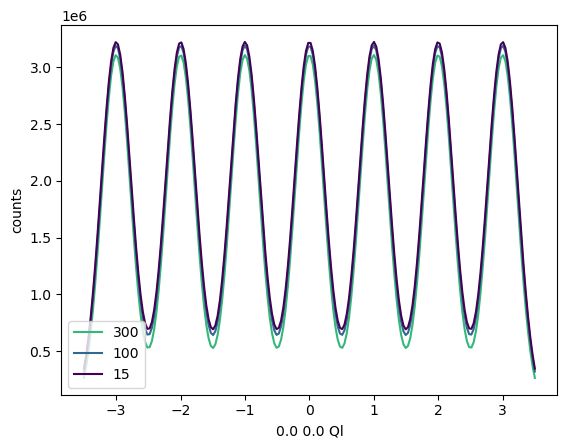

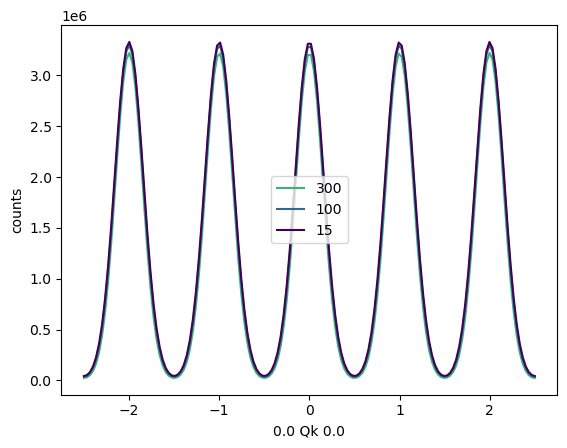

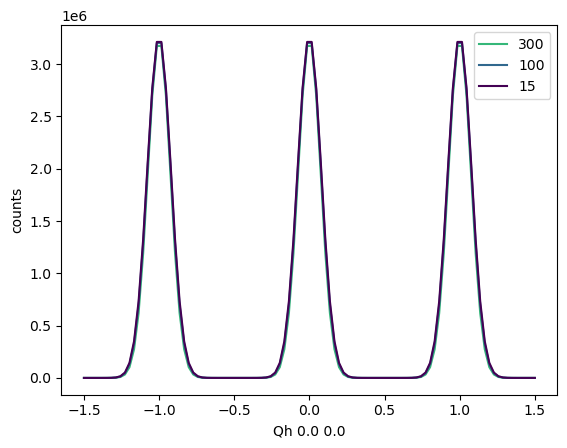

In [86]:
xtl.cut_data(center=(0,0,0), window=(0.1,0.1,5.0))
xtl.plot_linecuts()

xtl.cut_data(center=(0,0,0), window=(0.1,5.0,0.1))
xtl.plot_linecuts()

xtl.cut_data(center=(0,0,0), window=(5.0,0.1,0.1))
xtl.plot_linecuts()

[None]

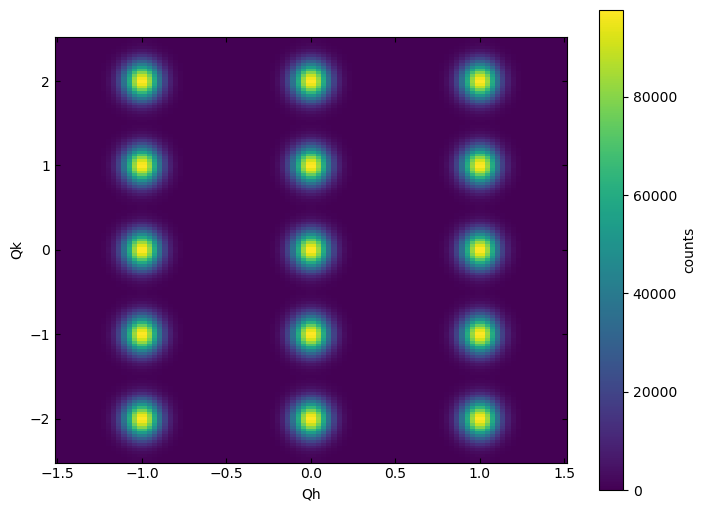

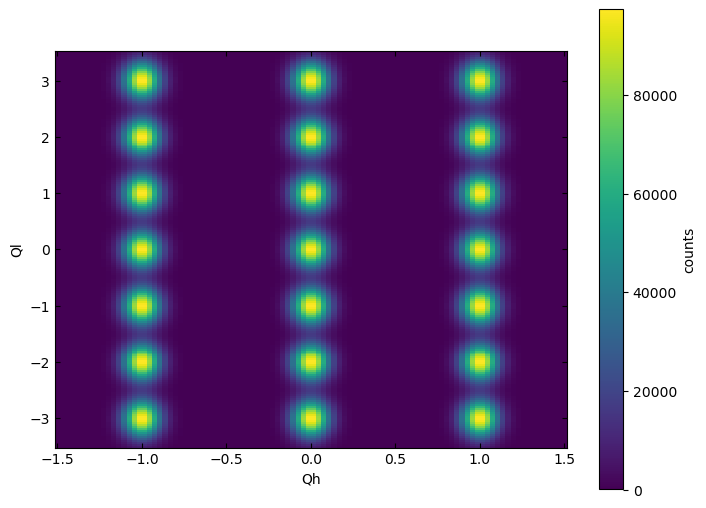

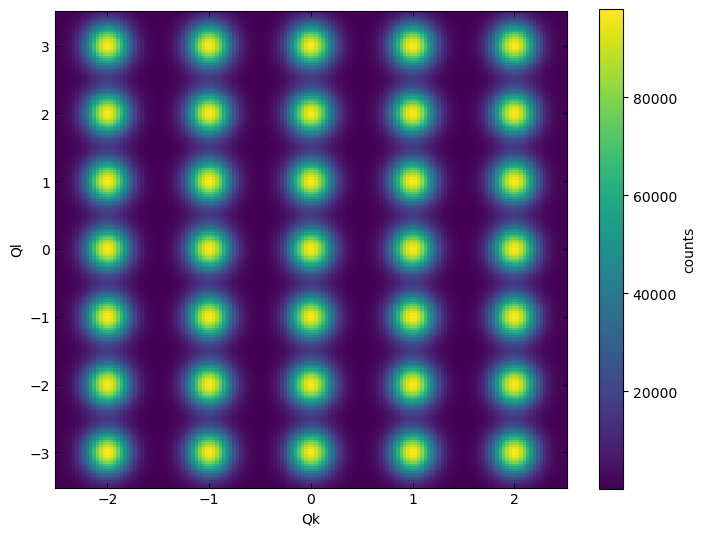

In [91]:
plot_slice(xtl.datasets['300'][:,:,0.0])
plt.gca().set(aspect=1/2)

plot_slice(xtl.datasets['300'][:,0.0,:])
plt.gca().set(aspect=1/3)

plot_slice(xtl.datasets['300'][0.0,:,:])
plt.gca().set(aspect=2/3)